In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/My Drive/Colab Notebooks/huawei/project/generations/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pymorphy2

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.datasets import fetch_20newsgroups

from nltk import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2
import re


import os
import time
import json
import tqdm
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


def save_texts(texts, titles, filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='w') as f:
    json.dump({'texts': texts, 'titles': titles}, f)

def load_texts(filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='r') as f:
    data = json.load(f)
  return data['texts'], data['titles']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using cpu


# Preprocess ria news


In [0]:
source_file = "processed-ria.json"
titles = []
texts = []

bad_text = []

with open(file=os.path.join(root, source_file), mode='r') as f:
  # lines = f.readlines()[:100]
  for _ in tqdm.tqdm(range(100000)):
    line = f.readline()
    try:
      line_j = json.loads(line)
      text = nltk.sent_tokenize(BeautifulSoup(line_j['text'], "lxml").text)[1]
      titles.append(line_j['title'])
      texts.append(text)
    except IndexError:
      bad_text.append(line_j)

100%|██████████| 100000/100000 [02:25<00:00, 689.28it/s]


In [0]:
morph = pymorphy2.MorphAnalyzer()
pattern = re.compile("^[а-яА-Я]+$")

texts_processed = []
titles_processed = []

def process_sentence(sentence):
    words = [w for w in nltk.word_tokenize(sentence) if w not in stopwords.words("russian") and pattern.match(w)]
    words = [morph.parse(word)[0].normal_form for word in words]
    return words

for text_i in tqdm.tqdm(range(len(texts))):
  try:
    # sentences = nltk.sent_tokenize(texts[text_i])
    # texts_processed.append(process_sentence(sentences[0]))
    texts_processed.append(process_sentence(texts[text_i]))
    titles_processed.append(process_sentence(titles[text_i]))
  except IndexError as e:
    print(e)
    print(text_i)

texts = texts_processed
titles = titles_processed
save_texts(texts, titles)

100%|██████████| 98148/98148 [16:33<00:00, 98.74it/s] 


# Load data

In [0]:
texts, titles = load_texts("ria_text_titles.json")

In [0]:
texts, titles = texts[:10000], titles[:10000]

Read 10000 sentence pairs
Counted words:
ru 19125
(['похороны', 'сотрудник', 'служба', 'специальный', 'назначение', 'фсб', 'россия', 'житель', 'ставропольский', 'край', 'старший', 'прапорщик', 'денис', 'романов', 'который', 'погибнуть', 'ход', 'спецоперация', 'уничтожение', 'боевик', 'территория', 'республика', 'дагестан', 'состояться', 'суббота', 'ессентуки', 'сообщить', 'риа', 'новость', 'представительница', 'глава', 'край'], ['погибший', 'дагестан', 'спецназовец', 'похоронить', 'ставрополье'])
['роджер', 'федерер', 'четыре', 'свой', 'карьера', 'выиграть', 'открытый', 'чемпионат', 'австралия', 'теннис']
['роджер', 'федерер', 'четыре', 'выиграть', 'открытый', 'чемпионат', 'австралия']


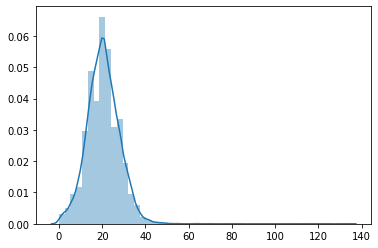

In [0]:
SOS_token = 0 # start of string.
EOS_token = 1 # end of string.
PAD_token = 2

class Lang: # like a vocabulary
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "PAD": PAD_token}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", PAD_token: "PAD"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



def prepareData(texts, titles):
    pairs = list(zip(texts, titles))
    lang = Lang('ru')

    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor)


lang, pairs = prepareData(texts, titles)
print(random.choice(pairs))

lens = [len(t) for t in texts]
sns.distplot(lens)

i = 100
print(texts[i])
print(titles[i])

# Prepear word embeddings

In [0]:
from random import shuffle

union = []
for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[0]+['EOS'])

for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[1]+['EOS'])

shuffle(union)

100%|██████████| 10000/10000 [00:00<00:00, 717612.92it/s]


In [0]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

model = Word2Vec(union, 
                 min_count = 0, 
                 workers=cpu_count(),
                 size=100,
                 window=10,
                 negative=5
                )

In [0]:
init_voc = set(lang.word2index.keys())
wv_voc = set(model.wv.vocab.keys())
print(wv_voc - init_voc)
print(init_voc - wv_voc)
# assert(len(init_voc)==len(wv_voc))

set()
{'PAD'}


In [0]:
word_init_vectors = {}
for w in model.wv.vocab:
    word_init_vectors[w] = model[w].tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Train


In [0]:
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(10)]
training_pair = training_pairs[0]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

def indices_to_text(sentence):
  print([lang.index2word[w.tolist()] for w in sentence])

indices_to_text(input_tensor)
indices_to_text(target_tensor)

['государственный', 'долг', 'австрия', 'конец', 'год', 'составить', 'миллиард', 'евро', 'сообщить', 'понедельник', 'газета', 'пресса', 'ссылка', 'министерство', 'финансы', 'страна', 'EOS']
['госдолг', 'австрия', 'вырасти', 'год', 'миллиард', 'евро', 'EOS']


In [0]:
# encoder: 3 layer lstm. 
# gets input idices
# returns hidden states for each word and 

learning_rate = 0.001
hidden_size = 100


global_embeddings = nn.Embedding(lang.n_words, hidden_size)
wv = torch.Tensor([word_init_vectors[lang.index2word[idx]] for idx in lang.index2word.keys()])
global_embeddings.weight.data = wv

encoder_gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

decoder_gru = nn.GRU(hidden_size*2, hidden_size, batch_first=True) 
decoder_linear = nn.Linear(hidden_size, lang.n_words)


encoder_optimizer = optim.Adam(list(encoder_gru.parameters())+list(global_embeddings.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(list(decoder_gru.parameters())+list(decoder_linear.parameters()), lr=learning_rate)

In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


class HeadlinesDataset(Dataset):
    def __init__(self, pairs, lang):
        self.pairs = pairs
        self.lang = lang
        self.text_max_length = max([len(p[0]) for p in pairs])
        self.title_max_length = max([len(p[1]) for p in pairs])
        
    def __getitem__(self, index):
        text, title = tensorsFromPair(self.pairs[index])
        if self.text_max_length+1-len(text) > 0:
          text  = torch.cat([text, torch.tensor([self.lang.word2index["PAD"]]*(self.text_max_length+1-len(text)))], dim=0)
        if self.title_max_length+1-len(title) > 0:
          title  = torch.cat([title, torch.tensor([self.lang.word2index["PAD"]]*(self.title_max_length+1-len(title)))], dim=0)
        return (text, title)

    def __len__(self):
        return len(self.pairs)


train_dataset = HeadlinesDataset(pairs, lang)

In [0]:
try:
  del criterion
  del encoder_optimizer
  del decoder_optimizer
  del loss
except:
  print("init")
  pass

batch_size = 1024 # 1024
n_epochs = 10 # 5
learning_rate = 0.01

# criterion = nn.NLLLoss(ignore_index=lang.word2index['PAD'])
criterion = nn.NLLLoss()
encoder_optimizer = optim.Adam(list(encoder_gru.parameters())+list(global_embeddings.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(list(decoder_gru.parameters())+list(decoder_linear.parameters()), lr=learning_rate)

In [0]:
losses = []


for n_epoch in range(n_epochs):
  epoch_loss = 0
  recalls = []
  train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  for input_tensors, target_tensors in tqdm.tqdm(train_dataloader):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs = torch.zeros(input_tensors.shape[0], input_tensors.shape[1], hidden_size, device=device)
    encoder_hidden =  torch.zeros(1, input_tensors.shape[0], hidden_size, device=device) # 1 = num_layers * num_directions
    
    embedded = global_embeddings(input_tensors)
    
    encoder_output, encoder_hidden = encoder_gru(embedded, encoder_hidden)
    decoder_hidden = encoder_hidden

    attn_weigths = nn.functional.softmax(torch.bmm(encoder_output, decoder_hidden.squeeze(0).unsqueeze(-1)), dim=0)
    attn_applied =  torch.bmm(encoder_output.permute(0, 2, 1), attn_weigths).permute(0,2,1)
    attn_applied = attn_applied.repeat(1, target_tensors.shape[-1], 1)
    decoder_input = torch.cat([global_embeddings(target_tensors), attn_applied], dim=2) # Teacher forcing

    decoder_output, decoder_hidden = decoder_gru(decoder_input, decoder_hidden)
    decoder_predict = torch.nn.functional.log_softmax(decoder_linear(decoder_output), dim=-1)

    preds = torch.argmax(decoder_predict, dim=-1)
    preds = preds.view(-1)
    mask = (target_tensors != lang.word2index['PAD']).view(-1)
    preds = preds[mask]
    targets = target_tensors.view(-1)[mask]
    delimenter = len(preds)
    good = sum(preds == targets)
    recalls.append(1.0*good / delimenter)

    loss = criterion(torch.cat(decoder_predict.unbind())[mask], target_tensors.view(-1)[mask])
    epoch_loss += loss.item()

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()


  losses.append(epoch_loss)
  # print(f"epoch: {n_epoch} - loss: {epoch_loss} - mean recall: {(sum(recalls)/len(recalls)).item()}")
  print(f"epoch: {n_epoch} - loss: {epoch_loss} - mean recall: {(sum(recalls)/len(recalls))}")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 - loss: 53.23679780960083 - mean recall: 0.24640889465808868


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 - loss: 39.02521729469299 - mean recall: 0.4379847049713135


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2 - loss: 26.55916118621826 - mean recall: 0.678946852684021


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 3 - loss: 16.48133420944214 - mean recall: 0.8199704885482788


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 4 - loss: 9.78426045179367 - mean recall: 0.8947517275810242


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 5 - loss: 5.824946403503418 - mean recall: 0.9468778371810913


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 6 - loss: 3.392800062894821 - mean recall: 0.9847249984741211


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 7 - loss: 1.8423783481121063 - mean recall: 0.9961973428726196


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 8 - loss: 0.9222106635570526 - mean recall: 0.9990741610527039


100%|██████████| 10/10 [01:30<00:00,  9.06s/it]

epoch: 9 - loss: 0.4821751266717911 - mean recall: 0.9998641014099121


# look into caches

10
10000


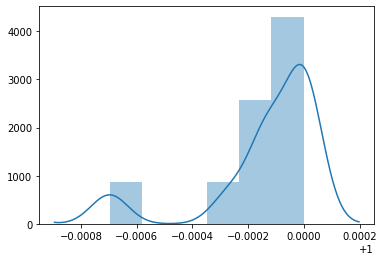

In [0]:
print(len(recalls))
print(len(pairs))
sns.distplot(recalls)

# Inference

In [0]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
for input_tensors, target_tensors in train_dataloader:
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  encoder_outputs = torch.zeros(input_tensors.shape[0], input_tensors.shape[1], hidden_size, device=device)
  encoder_hidden =  torch.zeros(1, input_tensors.shape[0], hidden_size, device=device) # 1 = num_layers * num_directions
  
  embedded = global_embeddings(input_tensors)
  
  encoder_output, encoder_hidden = encoder_gru(embedded, encoder_hidden)
  decoder_hidden = encoder_hidden

  attn_weigths = nn.functional.softmax(torch.bmm(encoder_output, decoder_hidden.squeeze(0).unsqueeze(-1)), dim=0)
  attn_applied =  torch.bmm(encoder_output.permute(0, 2, 1), attn_weigths).permute(0,2,1)
  attn_applied = attn_applied.repeat(1, target_tensors.shape[-1], 1)
  decoder_input = torch.cat([global_embeddings(target_tensors), attn_applied], dim=2) # Teacher forcing

  decoder_output, decoder_hidden = decoder_gru(decoder_input, decoder_hidden)
  decoder_predict = torch.nn.functional.log_softmax(decoder_linear(decoder_output), dim=-1)

  preds = torch.argmax(decoder_predict, dim=-1)
  break

In [0]:
def ids2text(seq):
  print([lang.index2word[w.detach().numpy().tolist()] for w in seq])

sample_i = 0
print(preds[sample_i])
ids2text(preds[sample_i])
ids2text(target_tensors[sample_i])

['мировой', 'цена', 'нефть', 'понизиться', 'EOS', 'место', 'место', 'место', 'место', 'место', 'место', 'место', 'место', 'место']
